# Solitaire Gameplay (Simple Version)

In [1]:
import pprint
import random
import numpy as np

In [2]:
class Card:

    def __init__(self, suit, value):
        """Initialize the Card class. Each card belongs to a suit, has
        a value, and can be flipped or not.
        """
        self.suit = suit
        self.value = value
        self.flipped = False

    def flip(self):
        """Flip a card. If a card is currently face_down, set it to face_up,
        and vice versa.
        """
        self.flipped = not self.flipped

    def __str__(self):
        """Return the suit and value of a card, e.g. "3 ♠".
        """
        return(f"{self.value} {self.suit}")

In [4]:
class Deck:

    def __init__(self, values, suits):
        self.cards = []
        self.cache = []
        self.populate(values, suits)
        self.shuffle()

    def __str__(self):
        return ", ".join([str(card) for card in self.cards])

    def populate(self, values, suits):
        for suit in suits:
            for value in values:
                this_card = Card(suit, value)
                self.cards.append(this_card)

    def shuffle(self):
        random.shuffle(self.cards)

    def get_first_card(self):
        if len(self.cards) > 0:
            return self.cards[0]
        else:
            return None

    def take_first_card(self, flip=True):
        if len(self.cards) > 0:
            next_card = self.cards.pop(0)
            if flip and len(self.cards) > 0:
                self.cards[0].flip()
            return next_card
        else:
            return None

    def draw_card(self):
        if len(self.cards) > 0:
            self.cards[0].flip()
            self.cards.append(self.cards.pop(0))
            self.cards[0].flip()

In [5]:
class Stack:

    def __init__(self):
        """Initialize the Stack class.
        """
        self.cards = []

    def add_card(self, Card):
        """Add a card to a stack. Inserts the card into the first position.
        """
        self.cards.insert(0, Card)

    def flip_first_card(self):
        """Flip the first card in the stack if there are cards in the stack.
        """
        if len(self.cards) > 0:
            self.cards[0].flip()

    def get_face_up_cards(self):
        """Return the cards in the stack that are currently face_up.
        """
        return [card for card in self.cards if card.flipped]

    def __str__(self):
        """Return the current stack as the number of face_down cards and then
        each face_up card by value and suit.
        """
        returned_cards = [str(card) for card in reversed(
            self.get_face_up_cards())]
        face_down_count = len(self.cards) - len(self.get_face_up_cards())
        if face_down_count > 0:
            returned_cards.insert(0, f"{face_down_count} cards face down.")
        return ", ".join(returned_cards)

In [6]:
class Game:

    values = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

    suits = { # Keys are unicode symbols for suits.
        u'\u2660': "black", # Spade
        u'\u2661': "red", # Hearts
        u'\u2663': "black", # Clubs
        u'\u2662': "red", # Diamonds
    }

    def __init__(self):
        """Initialize the Game class.
        """
        self.moves = 0
        
        # Instantiate the Deck.
        self.deck = Deck(self.values, self.suits)

        # Instantiate the Stacks.
        self.play_stacks = []

        # For each of the seven stacks...
        for i in range(7):
            this_stack = Stack()
            # ...take the first card from the Deck without flipping it and add
            # it to the current stack by inserting it into the first position.
            # The first stack will have 1 card, the second 2...the last, 7.
            [this_stack.add_card(self.deck.take_first_card(flip=False))
             for j in range(i + 1)]
            # Flip the topmost card in the stack.
            this_stack.flip_first_card()
            # Add the populated stack to the list of playable stacks.
            self.play_stacks.append(this_stack)

        # Populate the four Ace stacks.
        self.ace_stacks = {suit: Stack() for suit in self.suits}

        # Flip the first card in the Deck.
        self.deck.cards[0].flip()

    def show_board(self):
        board = {
            "deck": str(self.deck),
            "stacks": [str(stack) for stack in self.play_stacks],
            "ace stacks": {suit: str(stack) for suit, stack in
                           self.ace_stacks.items()}
        }
        return board

    def check_card_order(self, higher, lower):
        """Determine whether or not two cards can be placed consecutively. Make
        sure that both cards are of differing suits with suits_different. Then,
        ensure that the cards are consecutive with values_consecutive by check-
        ing that the value of the higher card is exactly one more than the
        value of the lower one. If both criteria are met, then the card order
        is allowed.
        """
        suits_different = self.suits[higher.suit] != self.suits[lower.suit]
        values_consecutive = self.values[self.values.index(higher.value)
                                        - 1] == lower.value
        return suits_different and values_consecutive

    def win(self):
        """Determine when the game is won. Deck must be empty, stacks must be
        empty, and Ace stacks must be full.
        """
        deck_empty = len(self.deck.cards) == 0
        stacks_empty = all(len(stack.cards) == 0 for stack in self.play_stacks)
        aces_full = all(len(stack.cards) == 13 for suit,
                        stack in self.ace_stacks.items())
        return deck_empty and stacks_empty and aces_full

    def add_to_ace_stack(self, card):
        """See if the current card can be added to the corresponding Ace stack.
        """
        if card is None: # do nothing if there is no current card
            return False
        # If there are cards in the Ace stack...
        elif len(self.ace_stacks[card.suit].cards) > 0:
            # ...get the value of topmost card.
            highest_value = self.ace_stacks[card.suit].cards[0].value
            # Check if value of the current card is higher than the topmost.
            if self.values[self.values.index(highest_value) + 1] == card.value:
                # If so, play the card to the corresponding Ace stack.
                self.ace_stacks[card.suit].cards.insert(0, card)
                return True
        else:
            # Immediately play any Ace to its corresponding stack.
            if card.value == "A":
                self.ace_stacks[card.suit].cards.insert(0, card)
                return True
            else:
                return False

    def take_simple_turn(self, verbose=False):
        """The possible actions for each turn is as follows:

        1. Make sure first card in each play pile is flipped up
        2. Move any eligible cards to the block piles
        3. If possible, move any kings to any empty play pile
        4. If possible, add drawn card to a play pile
        5. Permute flipped up cards in the play piles to see if any of them can
        be switched around. Only move cards between play piles if the number of
        cards faced down in the old pile is more than the number of cards face
        down in the new pile.
        6. Draw new card

        The algorithm will pick the first item on the list that is successful,
        and restart from the top on the next turn.
        """

        #0: Flip any face_down cards at the end of the stack.
        [stack.cards[0].flip() for stack in self.play_stacks if len(
            stack.cards) > 0 and not stack.cards[0].flipped]

        #1: Check if there are any cards that are playable to an Ace stack.
        for stack in self.play_stacks:
            # If there are cards in the stack and the topmost card can be
            # added to its corresponding Ace stack...
            if len(stack.cards) > 0 and self.add_to_ace_stack(stack.cards[0]):
                card_added = stack.cards.pop(0)
                if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from board to Ace stack")
                return True

        #2: Check if any cards in the deck are playable to an Ace stack.
        if self.add_to_ace_stack(self.deck.get_first_card()):
            card_added = self.deck.take_first_card()
            if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from deck to Ace stack")
            return True

        #3: Move Kings to open stacks.
        for stack in self.play_stacks:
            # If there are no cards in the stack...
            if len(stack.cards) == 0:
                # ...first, check all of the other stacks...
                for pile in self.play_stacks:
                    # ...for a King.
                    if len(pile.cards) > 1 and pile.cards[0].value == "K":
                        card_added = pile.cards.pop(0)
                        # Place the King in the empty stack.
                        stack.add_card(card_added)
                        if verbose == True:
                            print(f"Move {self.moves}: Move {str(card_added)} to empty stack")
                        return True
                # Then, check the deck for a King.
                if self.deck.get_first_card() is not None and self.deck.get_first_card().value == "K":
                    card_added = self.deck.take_first_card()
                    stack.add_card(card_added)
                    if verbose == True:
                        print(f"Move {self.moves}: Play {str(card_added)} from deck to empty stack")
                    return True

        #4: Add drawn card to playable stack.
        for stack in self.play_stacks:
            # For each non-empty stack...
            if len(stack.cards) > 0 and self.deck.get_first_card() is not None:
                # ...check that the cards are in an allowable order.
                if self.check_card_order(stack.cards[0],
                                         self.deck.get_first_card()):
                    # Add the card to the stack.
                    card_added = self.deck.take_first_card()
                    stack.add_card(card_added)
                    if verbose == True:
                        print(f"Move {self.moves}: Play {str(card_added)} from deck to board")
                    return True

        #5: Move cards around playable stacks.
        # For each stack on the board...
        for stack in self.play_stacks:
            # ...get all the face_up cards in that stack.
            stack_face_up = stack.get_face_up_cards()
            # If there are face_up cards in the stack...
            if len(stack_face_up) > 0:
                # ...check every other playable stack.
                for pile in self.play_stacks:
                    # Get all the face_up cards in the pile.
                    pile_face_up = pile.get_face_up_cards()
                    # If there are face_up cards in a different stack...
                    if pile is not stack and len(pile_face_up) > 0:
                        # ...choose how many cards to move.
                        for num_cards_to_move in range(1,
                                                       len(pile_face_up) + 1):
                            cards_to_move = stack_face_up[:num_cards_to_move]
                            # Check if the card order is allowable.
                            if self.check_card_order(pile.cards[0],
                                                     cards_to_move[-1]):
                                stack_face_down = len(stack.cards) - len(
                                    stack_face_up)
                                pile_face_down = len(pile.cards) - len(
                                    pile_face_up)
                                if pile_face_down < stack_face_down:
                                    [pile.cards.insert(
                                        0, card) for card in reversed(
                                            cards_to_move)]
                                    stack.cards = stack.cards[num_cards_to_move:]
                                    if verbose == True:
                                        print(f"Move {self.moves}: Move {num_cards_to_move} cards between piles")
                                    return True
                                elif stack_face_down == 0 and len(
                                    cards_to_move) == len(stack.cards):
                                    [pile.cards.insert(
                                        0, card) for card in reversed(
                                            cards_to_move)]
                                    stack.cards = []
                                    if verbose == True:
                                        print(f"Move {self.moves}: Move {num_cards_to_move} cards between piles")
                                    return True
        return False

    def simulate(self, draw=False, verbose=False):
        self.moves += 1

        if verbose==True:
            print()
            pp.pprint(play.show_board())
            print(); print()
            
        # Clear cache if last turn wasn't a card draw.
        if not draw:
            self.deck.cache = []

        # Take a turn.
        turn_result = self.take_simple_turn(verbose=verbose)
        #if self.moves > 0 and verbose==True:
            #print(f"Move {self.moves}: {action}")

        # If the turn was successful, take another.
        if turn_result:
            self.simulate(verbose=verbose)

        else:
            # Try to draw from deck.
            if len(self.deck.cards) > 0:
                current_card = self.deck.cards[0]

                if current_card in self.deck.cache:
                    if verbose == True:
                        print("No more moves left!")
                        print(f"Moves: {self.moves}")
                    return

                else:
                    self.deck.draw_card()
                    if verbose == True:
                        print(f"Move {self.moves}: Draw a card")
                    self.deck.cache.append(current_card)
                    return self.simulate(draw=True, verbose=verbose)

            else:
                if verbose == True:
                    print("No more moves left!")
                    print(f"Moves: {self.moves}")
                return


## Test

In [7]:
pp = pprint.PrettyPrinter(indent = 4)

verbose = True

play = Game()
play.simulate(verbose = verbose)

if(play.win()):
    result = 1
    if verbose == True:
        print("You won!")
else:
    result = 0
    if verbose == True:
        print("You lost! Try again.")


{   'ace stacks': {'♠': '', '♡': '', '♢': '', '♣': ''},
    'deck': '4 ♢, J ♣, 8 ♣, J ♢, 9 ♣, Q ♡, 3 ♢, 5 ♠, 6 ♢, 6 ♠, 3 ♣, K ♣, 7 ♡, '
            'Q ♠, A ♠, 10 ♢, 9 ♠, J ♠, 4 ♡, K ♠, 2 ♣, 7 ♢, 8 ♢, 9 ♡',
    'stacks': [   '9 ♢',
                  '1 cards face down., 10 ♠',
                  '2 cards face down., 8 ♡',
                  '3 cards face down., 5 ♣',
                  '4 cards face down., 2 ♡',
                  '5 cards face down., 10 ♡',
                  '6 cards face down., 4 ♣']}


Move 1: Play 4 ♢ from deck to board

{   'ace stacks': {'♠': '', '♡': '', '♢': '', '♣': ''},
    'deck': 'J ♣, 8 ♣, J ♢, 9 ♣, Q ♡, 3 ♢, 5 ♠, 6 ♢, 6 ♠, 3 ♣, K ♣, 7 ♡, Q ♠, '
            'A ♠, 10 ♢, 9 ♠, J ♠, 4 ♡, K ♠, 2 ♣, 7 ♢, 8 ♢, 9 ♡',
    'stacks': [   '9 ♢',
                  '1 cards face down., 10 ♠',
                  '2 cards face down., 8 ♡',
                  '3 cards face down., 5 ♣, 4 ♢',
                  '4 cards face down., 2 ♡',
                  '5 cards face down., 10 ♡'

## Run

In [8]:
pp = pprint.PrettyPrinter(indent = 4)

runs = []
moves = []
verbose = False

for i in range(1):
    play = Game()
    play.simulate(verbose = verbose)

    if(play.win()):
        result = 1
        if verbose == True:
            print("You won!")
    else:
        result = 0
        if verbose == True:
            print("You lost! Try again.")
    
    runs.append(result)
    moves.append(play.moves)
    
print(f"Num wins: {sum(runs)}\nWin rate: {sum(runs)/len(runs)}\nAvg. num moves: {np.mean(moves)}")

Num wins: 0
Win rate: 0.0
Avg. num moves: 50.0


## Betting

In [9]:
pp = pprint.PrettyPrinter(indent = 4)

# Set up betting info

buyin_fee = 1.50
place_amount = 0.50
bonus_amount = 5.00

runs = []
moves = []
payouts = []
verbose = False

for i in range(1000):
    payout = 0
    play = Game()
    play.simulate(verbose = verbose)

    if(play.win()):
        result = 1
        payout += (52*place_amount) + bonus_amount
        if verbose == True:
            print("You won!")
    else:
        result = 0
        placed = [np.sum([1 for card in play.ace_stacks[i].cards]) for i in list(play.ace_stacks.keys())]
        payout += np.sum(placed) * place_amount
        if verbose == True:
            print("You lost! Try again.")
    
    runs.append(result)
    moves.append(play.moves)
    payouts.append(payout - buyin_fee)

print(f"Num wins: {sum(runs)}\nWin rate: {sum(runs)/len(runs)}\nAvg. num moves: {np.mean(moves)}\nAvg. prize amount: {np.mean(payouts)}")

Num wins: 0
Win rate: 0.0
Avg. num moves: 50.0
Avg. prize amount: 4.5


## Confidence Intervals

In [16]:
import matplotlib.pyplot as plt

### 10 trials of 100 runs each

```
{'wins': [0.02, 0.01, 0.02, 0.02, 0.0, 0.02, 0.01, 0.01, 0.02, 0.01],
 'earnings': [4.04, 4.595, 4.35, 3.96, 4.16, 4.56, 4.66, 4.02, 4.61, 3.86]}
```

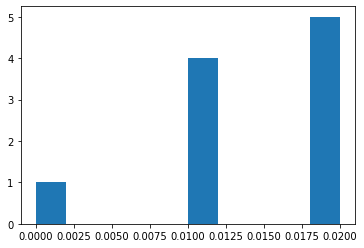

In [54]:
fig1a = plt.plot()
plt.hist(trials['wins'])
plt.show()

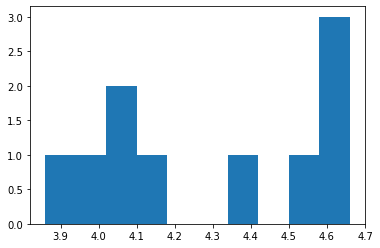

In [55]:
fig1b = plt.plot()
plt.hist(trials['earnings'])
plt.show()

### 50 trials of 100 runs each

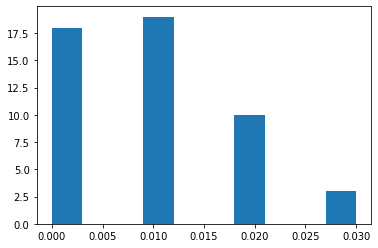

In [58]:
fig2a = plt.plot()
plt.hist(trials['wins'])
plt.show()

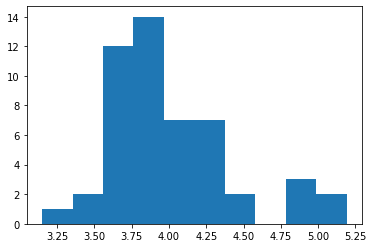

In [59]:
fig2b = plt.plot()
plt.hist(trials['earnings'])
plt.show()

### 100 trials of 100 runs each

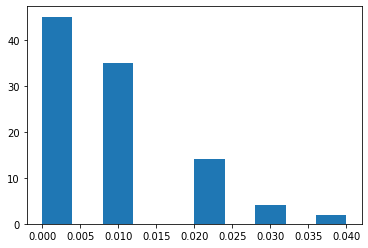

In [62]:
fig3a = plt.plot()
plt.hist(trials['wins'])
plt.show()

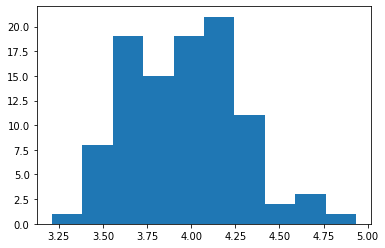

In [76]:
fig3b = plt.plot()
plt.hist(trials['earnings'])
plt.show()

### 1000 trials of 100 runs each

In [79]:
pp = pprint.PrettyPrinter(indent = 4)

trials = {
    'wins': [],
    'earnings': [],
}
buyin_fee = 1.50
place_amount = 0.50
bonus_amount = 5.00

# Run trials
for i in range(1000):
    # of 100 games each
    runs = []
    winnings = []
    for i in range(100):
        payout = 0
        play = Game()
        play.simulate(verbose = False)

        if(play.win()):
            runs.append(1)
            payout += (52*place_amount) + bonus_amount
        else:
            runs.append(0)
            placed = [np.sum([1 for card in play.ace_stacks[i].cards]) for i in list(play.ace_stacks.keys())]
            payout += np.sum(placed) * place_amount
        winnings.append(payout)
    
    trials['wins'].append(np.mean(runs))
    trials['earnings'].append(np.mean(winnings))

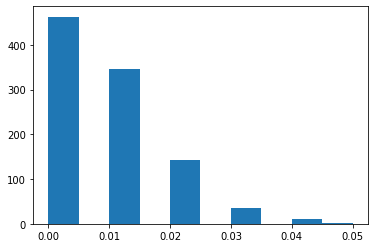

In [81]:
fig4c = plt.plot()
plt.hist(trials['wins'])
plt.show()

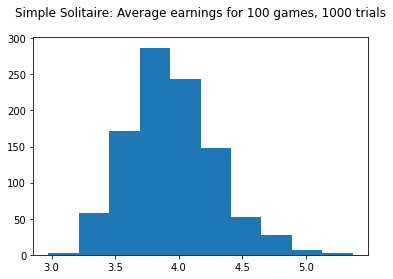

In [97]:
fig4b = plt.figure()
plt.hist(trials['earnings'])
plt.title("Simple Solitaire: Average earnings for 100 games, 1000 trials\n")
plt.show()

In [98]:
fig4b.savefig("earnings_for_1000-trials_100-runs.jpg")

In [99]:
np.mean(trials['earnings'])

3.9450550000000004

In [100]:
np.percentile(trials['earnings'], 2.5), np.percentile(trials['earnings'], 97.5)

(3.35975, 4.71)